In [1]:
.libPaths(R.home('/opt/homebrew/Caskroom/miniforge/base/lib/R/library'))

In [2]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.2. Data Processing/Output'
cur_date = '071725'

library(missForest)
library(readxl)
library(openxlsx)
library(tidyverse)
library(factoextra)
library(ggh4x)

# reading in files
ws_df = data.frame(Sample = 'WS', read_excel("Input/Woodsmoke_Data_053125.xlsx", sheet = 2)) %>%
    select(-Number)
wf_df = data.frame(Sample = 'WF', read_excel("Input/Wildfire_Data_053125.xlsx", sheet = 2)) %>%
    select(-Number)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [3]:
head(ws_df)
head(wf_df)

,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID6025648,1-Methylphenanthrene,NA
2,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID0025654,1-Methylpyrene,NA
3,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID4020878,2-Methylnaphthalene,NA
4,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID4063030,2-Methylpyrene,NA
5,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID50187178,4-Methylpyrene,NA
6,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID6063143,5-Methylchrysene,NA


,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WF,1289737,Campbell et al. 2024,1,PAH,Weight,DTXSID1074759,1-Methylchrysene,NA
2,WF,1289737,Campbell et al. 2024,1,PAH,Weight,DTXSID9020877,1-Methylnaphthalene,NA
3,WF,1289737,Campbell et al. 2024,1,PAH,Weight,DTXSID0029187,"2,6-Dimethylnaphthalene",NA
4,WF,1289737,Campbell et al. 2024,1,PAH,Weight,DTXSID4020878,2-Methylnaphthalene,NA
5,WF,1289737,Campbell et al. 2024,1,PAH,Weight,DTXSID3061134,9-Methylanthracene,NA
6,WF,1289737,Campbell et al. 2024,1,PAH,Weight,DTXSID3023845,Acenaphthylene,NA


In [4]:
dim(ws_df)
dim(wf_df)

[1] 4391    9

[1] 3795    9

Starting with 4391 WS records and 3795 WF records. 

In [5]:
# combining dfs
combined_df = rbind(ws_df, wf_df)
           
head(combined_df)

,Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID6025648,1-Methylphenanthrene,NA
2,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID0025654,1-Methylpyrene,NA
3,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID4020878,2-Methylnaphthalene,NA
4,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID4063030,2-Methylpyrene,NA
5,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID50187178,4-Methylpyrene,NA
6,WS,429174,Arif et al. 2017,1,PAH,Weight,DTXSID6063143,5-Methylchrysene,NA


In [6]:
length(unique(combined_df$Name))
length(unique(ws_df$Name))
length(unique(wf_df$Name))

[1] 151

[1] 93

[1] 114

114 unique metals/chemicals total.

# Filter #1: Chemical/Metal Background Filters

Determining what variables have missing data for all variables delineated based on the dfs the data will be split into and analyzed. 

A variable (ie. `Name` which represents a chemical or metal) will be retained if >= 20% of its experimental data points were measurable values. In other words, chemicals or metals were excluded if they had NAs (not evaluated) or had non-detect values across >= 80% of the samples.

In [45]:
`%notin%` <- Negate(`%in%`)

sample_type_presence_df = combined_df %>%
    # if an experimental value is there count it as being "present"
    mutate(count = ifelse(Value %notin% c('NA', 'ND'), 1, 0)) %>%
    # determining which have at least 20% experimental values for each chemical/metal
    group_by(Metric, Sample, Name) %>%
    # calculating the percentage of experimental data points
    reframe(Variable_Presence_Percentage = (sum(count)/n()) * 100) %>%
    filter(Variable_Presence_Percentage >= 20) 

head(sample_type_presence_df)

Metric,Sample,Name,Variable_Presence_Percentage
<chr>,<chr>,<chr>,<dbl>
Volume,WF,"1,2,4-Trimethylbenzene",100.00000
Volume,WF,Acenaphthene,21.05263
Volume,WF,Acenaphthylene,100.00000
Volume,WF,Anthracene,42.10526
Volume,WF,Arsenic,100.00000
Volume,WF,Benz(a)anthracene,100.00000


In [46]:
# filtering the original df
filter1_df = inner_join(sample_type_presence_df[,1:3], combined_df) 

head(filter1_df)

Joining with `by = join_by(Metric, Sample, Name)`


Metric,Sample,Name,HAWC_ID,Study,Sample_Number,Class,DTXSID,Value
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
Volume,WF,"1,2,4-Trimethylbenzene",1289926,Wang et al. 2024,1,VOC,DTXSID6021402,730
Volume,WF,"1,2,4-Trimethylbenzene",1306371,Ketcherside et al. 2024,1,VOC,DTXSID6021402,130
Volume,WF,Acenaphthene,1289895,Silberstein et al. 2023,1,PAH,DTXSID3021774,0.16
Volume,WF,Acenaphthene,1286055,Simms et al. 2021,1,PAH,DTXSID3021774,NA
Volume,WF,Acenaphthene,1285830,Navarro et al. 2019,1,PAH,DTXSID3021774,2
Volume,WF,Acenaphthene,1285830,Navarro et al. 2019,2,PAH,DTXSID3021774,2


In [47]:
dim(combined_df)
dim(filter1_df)

[1] 8186    9

[1] 6548    9

Started with 8186 records, 1638 were removed, leaving 6548. 

# Filter #2: Study Background Filter

A study will be retained if >= 20% of its experimental data points were measurable values. In other words, chemicals were excluded if they were NAs (not evaluated) or had non-detect values across < 20% of the samples.

In [48]:
study_type_presence_df = filter1_df %>%
    # if an experimental value is there count it as being "present"
    mutate(count = ifelse(Value %notin% c('NA', 'ND'), 1, 0)) %>%
    # determining which have at least 20% experimental values for each chemical/metal
    group_by(Metric, Class, HAWC_ID) %>%
    # calculating the percentage of experimental data points
    reframe(Study_Presence_Percentage = (sum(count)/n()) * 100) %>%
    filter(Study_Presence_Percentage >= 20) 

head(study_type_presence_df)

Metric,Class,HAWC_ID,Study_Presence_Percentage
<chr>,<chr>,<dbl>,<dbl>
Volume,Metal,266980,100
Volume,Metal,266987,100
Volume,Metal,452289,100
Volume,Metal,885041,100
Volume,Metal,993956,100
Volume,Metal,1070627,100


In [49]:
filter2_df = inner_join(study_type_presence_df[,1:3], filter1_df)

head(filter2_df)

Joining with `by = join_by(Metric, Class, HAWC_ID)`


Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,DTXSID,Value
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
Volume,Metal,266980,WS,Lead,Stockfelt et al. 2012,1,Pb,170
Volume,Metal,266980,WS,Lead,Stockfelt et al. 2012,2,Pb,400
Volume,Metal,266980,WS,Potassium,Stockfelt et al. 2012,1,K,9700
Volume,Metal,266980,WS,Potassium,Stockfelt et al. 2012,2,K,8800
Volume,Metal,266980,WS,Zinc,Stockfelt et al. 2012,1,Zn,2400
Volume,Metal,266980,WS,Zinc,Stockfelt et al. 2012,2,Zn,3100


In [50]:
dim(filter1_df)
dim(filter2_df)

[1] 6548    9

[1] 6426    9

122 more records were removed.

# Filter #3: Chemical/Metal Background Filter

In the intial filter, WS and WF samples were combined. However, this time variables (ie. metal or chemical) will be split based on their `Metric` (ie. volume or weight) and then retained if that variable is found in both woodsmoke and wildfire samples within volume or weight samples.

In [51]:
split_filtered_df = filter2_df %>%
    group_by(Sample, Metric) %>%
    group_split

split_ws_vol_df = split_filtered_df[[3]]
split_ws_weight_df = split_filtered_df[[4]]
split_wf_vol_df = split_filtered_df[[1]]
split_wf_weight_df = split_filtered_df[[2]]

In [52]:
# seeing how many unique variables are in each df and if they're consistent in each file
length(unique(split_ws_vol_df$Name))
length(unique(split_wf_vol_df$Name))
length(unique(split_ws_weight_df$Name))
length(unique(split_wf_weight_df$Name))

[1] 77

[1] 57

[1] 51

[1] 89

In [53]:
# they're not so first getting variables that are in weight or volume samples
consistent_wf_vol_df = split_wf_vol_df %>%
    filter(Name %in% unique(split_ws_vol_df$Name))
consistent_ws_vol_df = split_ws_vol_df %>%
    filter(Name %in% consistent_wf_vol_df$Name)
consistent_wf_weight_df = split_wf_weight_df %>%
    filter(Name %in% unique(split_ws_weight_df$Name))
consistent_ws_weight_df = split_ws_weight_df %>%
    filter(Name %in% consistent_wf_weight_df$Name)

length(unique(consistent_wf_vol_df$Name))
length(unique(consistent_ws_vol_df$Name))
length(unique(consistent_wf_weight_df$Name))
length(unique(consistent_ws_weight_df$Name))

[1] 37

[1] 37

[1] 37

[1] 37

There were 77, 57, 51 and 89 woodsmoke weight, woodsmoke volume, wildfire weight, and wildfire volume samples, respectively. 37 variables were common between volume samples and 37 were common between weight records and will be retained.

In [54]:
# recombining data
vol_df = rbind(consistent_ws_vol_df, consistent_wf_vol_df)
weight_df = rbind(consistent_ws_weight_df, consistent_wf_weight_df)

head(vol_df)

Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,DTXSID,Value
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
Volume,Metal,266980,WS,Lead,Stockfelt et al. 2012,1,Pb,170
Volume,Metal,266980,WS,Lead,Stockfelt et al. 2012,2,Pb,400
Volume,Metal,266980,WS,Potassium,Stockfelt et al. 2012,1,K,9700
Volume,Metal,266980,WS,Potassium,Stockfelt et al. 2012,2,K,8800
Volume,Metal,266980,WS,Zinc,Stockfelt et al. 2012,1,Zn,2400
Volume,Metal,266980,WS,Zinc,Stockfelt et al. 2012,2,Zn,3100


# Square Root Imputation

Taking the square root of the min value to impute MNAR data.

In [55]:
# first determining number of ND and NA values in each df
vol_df %>%
    filter(Value %in% c('NA', 'ND')| grepl("<", Value)) %>%
    group_by(Value) %>%
    summarize(n())

weight_df %>%
    filter(Value %in% c('NA', 'ND')| grepl("<", Value)) %>%
    group_by(Value) %>%
    summarize(n())

Value,n()
<chr>,<int>
NA,45
ND,27


Value,n()
<chr>,<int>
<0.00025,1
<0.0005,6
<0.0006,2
<0.0007,3
<0.037,1
<0.04,1
<0.05,1
NA,721
ND,211


In [56]:
dim(vol_df)
dim(weight_df)

[1] 1049    9

[1] 3248    9

In [57]:
# creating a df for MAR data
mar_weight_df = weight_df %>%
    filter(Value == 'NA')
mar_vol_df = vol_df %>%
    filter(Value == 'NA')

# creating dfs for studies that contain MNAR data
preimputed_lod_weight_df = anti_join(weight_df, mar_weight_df) 
preimputed_vol_df = anti_join(vol_df, mar_vol_df) 

Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, DTXSID, Value)`
Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, DTXSID, Value)`


In [58]:
# first imputing non detect values for studies that had a limit of detection (LOD) provided
lod_values_df = preimputed_lod_weight_df %>%
    filter(grepl("<", Value)) %>%
    separate(Value, sep = '<', into = c(NA, 'Value')) %>%
    mutate(Value = sqrt(as.numeric(Value)))

dim(lod_values_df)
head(lod_values_df)

# adding these newly imputed values back into the df
preimputed_weight_df = rbind(anti_join(preimputed_lod_weight_df, lod_values_df[,1:8]), lod_values_df)

[1] 15  9

Metric,Class,HAWC_ID,Sample,Name,Study,Sample_Number,DTXSID,Value
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
Weight,PAH,271571,WS,Acenaphthene,Dilger et al. 2016,1,DTXSID3021774,0.19235384
Weight,PAH,821855,WS,Acenaphthene,Erlandsson et al. 2020,1,DTXSID3021774,0.22360680
Weight,PAH,821855,WS,Naphthalene,Erlandsson et al. 2020,1,DTXSID8020913,0.20000000
Weight,PAH,1045457,WS,"Dibenzo(a,h)anthracene",Popadic 2018,1,DTXSID9020409,0.01581139
Weight,PAH,1289739,WF,Benzo(GHI)perylene,Campos et al. 2019,2,DTXSID5023908,0.02645751
Weight,PAH,1289739,WF,Benzo(GHI)perylene,Campos et al. 2019,6,DTXSID5023908,0.02645751


Joining with `by = join_by(Metric, Class, HAWC_ID, Sample, Name, Study,
Sample_Number, DTXSID)`


In [59]:
preimputed_weight_df$Value = as.numeric(preimputed_weight_df$Value)
preimputed_vol_df$Value = as.numeric(preimputed_vol_df$Value)
mar_weight_df$Value = as.numeric(mar_weight_df$Value)
mar_vol_df$Value = as.numeric(mar_vol_df$Value)

# reordering cols
preimputed_weight_df = preimputed_weight_df[,c(3,1,4,6,7,2,8,5,9)] %>%
    # normalizing data
    mutate(Value = log2(Value + 1))
preimputed_vol_df = preimputed_vol_df[,c(3,1,4,6,7,2,8,5,9)] %>%
    # normalizing data
    mutate(Value = log2(Value + 1))

head(preimputed_weight_df)

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


HAWC_ID,Metric,Sample,Study,Sample_Number,Class,DTXSID,Name,Value
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Cd,Cadmium,4.925999
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cd,Cadmium,NA
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Cr,Chromium,4.485427
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cr,Chromium,4.478972
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Cu,Copper,6.057450
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cu,Copper,5.145677


In [60]:
# creating a df for MNAR data
mnar_weight_df = preimputed_weight_df %>%
    filter(is.na(Value))
mnar_vol_df = preimputed_vol_df %>%
    filter(is.na(Value))

head(mnar_weight_df)

HAWC_ID,Metric,Sample,Study,Sample_Number,Class,DTXSID,Name,Value
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cd,Cadmium,NA
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Mn,Manganese,NA
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Mn,Manganese,NA
271638,Weight,WS,Jalava et al. 2012,1,Metal,Pb,Lead,NA
271638,Weight,WS,Jalava et al. 2012,2,Metal,Pb,Lead,NA
271638,Weight,WS,Jalava et al. 2012,3,Metal,Pb,Lead,NA


In [61]:
square_root_imputation = function(mnar_df, preimputed_df){
    # """
    # Imputing MNAR values based on the square root of the minimum concentration for each chemical 
    # within a study or metal.
    
    # :param: MNAR dataframe, preimputed dataframe
    # :output: a dataframe with imputed values

    # """

    id_df = mnar_df[is.na(mnar_df$Value),]
    study_ids = unique(id_df$HAWC_ID)
    
    imputed_df = data.frame()
    for (i in 1:length(id_df$HAWC_ID)){
    
        filtered_df = preimputed_df %>%
            filter(HAWC_ID == id_df$HAWC_ID[i], DTXSID == id_df$DTXSID[i])
    
        na_df = filtered_df %>%
            filter(is.na(Value)) %>%
            mutate(Value = sqrt(min(filtered_df$Value, na.rm = TRUE)))
    
        # combining rows of data
        combined_df = rbind(filtered_df %>%
            filter(!is.na(Value)), na_df)
    
        imputed_df = rbind(imputed_df, combined_df) %>%
                        unique()
    }
    return(imputed_df)    
    
}

# calling fn
imputed_vol_df = square_root_imputation(mnar_vol_df, preimputed_vol_df) %>%
    mutate(Value = ifelse(Value == Inf, NA, Value))
imputed_weight_df = square_root_imputation(mnar_weight_df, preimputed_weight_df) %>%
    mutate(Value = ifelse(Value == Inf, NA, Value))
    
head(imputed_weight_df)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Value = sqrt(min(filtered_df$Value, na.rm = TRUE))`.
Caused by warning in `min()`:
! no non-missing arguments to min; retur

HAWC_ID,Metric,Sample,Study,Sample_Number,Class,DTXSID,Name,Value
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Cd,Cadmium,4.925999
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cd,Cadmium,2.219459
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Mn,Manganese,NA
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Mn,Manganese,NA
271638,Weight,WS,Jalava et al. 2012,1,Metal,Pb,Lead,NA
271638,Weight,WS,Jalava et al. 2012,2,Metal,Pb,Lead,NA


In [62]:
# there are still a few variables that didn't have any values to do the square root imputation
# their imputed values will be based off of distributions from other studies
other_studies_vol_df = semi_join(preimputed_vol_df %>%
                filter(!is.na(Value)), imputed_vol_df %>%
                               filter(is.na(Value)) %>%
    select(2,3,6,7)) %>%
    group_by(DTXSID) %>%
    summarize(Value = sqrt(min(Value)))

other_studies_weight_df = semi_join(preimputed_weight_df %>%
                filter(!is.na(Value)), imputed_weight_df %>%
                               filter(is.na(Value)) %>%
    select(2,3,6,7)) %>%
    group_by(DTXSID) %>%
    summarize(Value = sqrt(min(Value)))

head(other_studies_vol_df)
dim(other_studies_vol_df)
head(other_studies_weight_df)
dim(other_studies_weight_df)

Joining with `by = join_by(Metric, Sample, Class, DTXSID)`
Joining with `by = join_by(Metric, Sample, Class, DTXSID)`


DTXSID,Value
<chr>,<dbl>
DTXSID0022432,0.28993838
DTXSID0023878,0.07867839
DTXSID0023907,0.30365678
DTXSID2020139,0.10920141
DTXSID3021774,0.46273622
DTXSID3024104,0.16902412


[1] 7 2

DTXSID,Value
<chr>,<dbl>
Al,1.2015018
Ba,1.0000000
Co,0.1198136
Cr,0.3708147
DTXSID0023907,0.1038260
DTXSID3021774,0.0724008


[1] 14  2

7 (volume) and 14 (weight) samples were imputed based on values from other studies.

In [63]:
# removing NAs from the imputed df 
removed_imputed_vol_df = imputed_vol_df %>%
    filter(!is.na(Value))
removed_imputed_weight_df = imputed_weight_df %>%
    filter(!is.na(Value))

# adding in the newly imputed values back in 
all_imputed_vol_df = left_join(imputed_vol_df %>%
        filter(is.na(Value)) %>%
        select(-Value), other_studies_vol_df)

all_imputed_weight_df = left_join(imputed_weight_df %>%
        filter(is.na(Value)) %>%
        select(-Value), other_studies_weight_df)

all_imputed_vol_df = rbind(removed_imputed_vol_df, all_imputed_vol_df)
all_imputed_weight_df = rbind(removed_imputed_weight_df, all_imputed_weight_df)

head(all_imputed_weight_df)

Joining with `by = join_by(DTXSID)`
Joining with `by = join_by(DTXSID)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Class,DTXSID,Name,Value
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Cd,Cadmium,4.925999
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cd,Cadmium,2.219459
271638,Weight,WS,Jalava et al. 2012,4,Metal,Si,Silicon,13.843627
271638,Weight,WS,Jalava et al. 2012,1,Metal,Si,Silicon,3.720702
271638,Weight,WS,Jalava et al. 2012,2,Metal,Si,Silicon,3.720702
271638,Weight,WS,Jalava et al. 2012,3,Metal,Si,Silicon,3.720702


In [64]:
# creating 1 df
mnar_imputed_vol_df = rbind(#imputed data
                               all_imputed_vol_df,
                               # adding in MAR data
                               mar_vol_df,
                               # adding back in non-imputed data
                               anti_join(preimputed_vol_df, all_imputed_vol_df[,1:8]))
mnar_imputed_weight_df = rbind(# imputed data
                               all_imputed_weight_df,
                               # adding in MAR data
                               mar_weight_df,
                               # adding back in non-imputed data
                               anti_join(preimputed_weight_df, all_imputed_weight_df[,1:8]))

head(mnar_imputed_weight_df)
dim(mnar_imputed_vol_df)
dim(mnar_imputed_weight_df)

Joining with `by = join_by(HAWC_ID, Metric, Sample, Study, Sample_Number,
Class, DTXSID, Name)`
Joining with `by = join_by(HAWC_ID, Metric, Sample, Study, Sample_Number,
Class, DTXSID, Name)`


HAWC_ID,Metric,Sample,Study,Sample_Number,Class,DTXSID,Name,Value
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
267105,Weight,WS,Danielsen et al. 2011,1,Metal,Cd,Cadmium,4.925999
267105,Weight,WS,Danielsen et al. 2011,2,Metal,Cd,Cadmium,2.219459
271638,Weight,WS,Jalava et al. 2012,4,Metal,Si,Silicon,13.843627
271638,Weight,WS,Jalava et al. 2012,1,Metal,Si,Silicon,3.720702
271638,Weight,WS,Jalava et al. 2012,2,Metal,Si,Silicon,3.720702
271638,Weight,WS,Jalava et al. 2012,3,Metal,Si,Silicon,3.720702


[1] 1049    9

[1] 3248    9

# Filter #4: Double Checking MAR Records

Making sure that when the data is split based on `Class` and transformed into a wide format, we have at least 20% of the records with numeric values for each metal or chemical. Converting values to 0s and 1s to count number of experimental and NDs previously imputed. Chemicals/metals that don't have at least 20% of values present will be removed.

In [65]:
wider_vol_df = mnar_imputed_vol_df %>%
    # creating sample ids
    unite("SampleID", c("Sample", "HAWC_ID", "Sample_Number"), remove = FALSE) %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") 

wider_weight_df = mnar_imputed_weight_df %>%
    # creating sample ids
    unite("SampleID", c("Sample", "HAWC_ID", "Sample_Number"), remove = FALSE) %>%
    select(-c("Name", "Class")) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value")

head(wider_weight_df)

SampleID,HAWC_ID,Metric,Sample,Study,Sample_Number,Cd,Si,Ca,Ni,⋯,Al,Ba,Co,Cu,Zn,K,Mg,DTXSID1025649,DTXSID4075459,DTXSID8074819
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WS_267105_1,267105,Weight,WS,Danielsen et al. 2011,1,4.925999,NA,NA,3.972693,⋯,NA,NA,NA,6.057450,10.009829,NA,NA,3.459432,NA,NA
WS_267105_2,267105,Weight,WS,Danielsen et al. 2011,2,2.219459,NA,NA,3.498251,⋯,NA,NA,NA,5.145677,9.552669,NA,NA,5.247928,NA,NA
WS_271638_4,271638,Weight,WS,Jalava et al. 2012,4,4.857981,13.843627,10.680360,NA,⋯,NA,NA,NA,NA,9.202124,14.90600,7.348728,NA,6.560715,NA
WS_271638_1,271638,Weight,WS,Jalava et al. 2012,1,2.807355,3.720702,10.156083,NA,⋯,NA,NA,NA,NA,7.971544,14.26598,6.507795,NA,8.950993,NA
WS_271638_2,271638,Weight,WS,Jalava et al. 2012,2,3.584963,3.720702,10.798472,NA,⋯,NA,NA,NA,NA,10.570804,17.88465,8.658211,NA,5.629357,NA
WS_271638_3,271638,Weight,WS,Jalava et al. 2012,3,2.807355,3.720702,9.616549,NA,⋯,NA,NA,NA,NA,8.915879,14.63827,6.087463,NA,9.881114,NA


In [67]:
data_percentage = function(wider_dataset){
    # """
    # Calculating the studies or metals/chemicals with less than or equal to 20% of experimental data.

    # :param: wide dataframe
    # :output: a list that contains a dataframe of metals/chemicals and a dataframe of studies

    # """
    
    # converting values to 0s and 1s
    summed_df = wider_dataset %>%
        mutate(across(7:ncol(wider_dataset), ~ifelse(is.na(.x), 0, 1)))

    # identifying metals/chemicals w/ =< 20% of experimental data
    var_percentage_df = data.frame(Percent = colSums(summed_df[,7:ncol(summed_df)])/nrow(summed_df) * 100) %>%
        filter(Percent <= 20)
    # identifying studies w/ =< 20% of experimental data
    study_percentage_df = data.frame(HAWC_ID = wider_dataset$HAWC_ID,
                                     Percent = rowSums(summed_df[,7:ncol(summed_df)])/ncol(summed_df) * 100) %>%
        filter(Percent <= 20)

    return(list(var_percentage_df, study_percentage_df))
}

# calling fn
percentage_vol_df = data_percentage(wider_vol_df)
percentage_weight_df = data_percentage(wider_weight_df)

head(percentage_weight_df[[1]])

,Percent
,<dbl>
Ba,17.058824
DTXSID1025649,5.294118
DTXSID8074819,4.117647


In [68]:
# removing those metals/chemicals & studies from the OG df
preimputed_vol_df = wider_vol_df[,colnames(wider_vol_df) %notin% rownames(percentage_vol_df[[1]])] 
preimputed_weight_df = wider_weight_df[,colnames(wider_weight_df) %notin% rownames(percentage_weight_df[[1]])]

preimputed_vol_df = preimputed_vol_df %>% filter(HAWC_ID %notin% percentage_vol_df[[2]]$HAWC_ID) 
preimputed_weight_df = preimputed_weight_df %>% filter(HAWC_ID %notin% percentage_weight_df[[2]]$HAWC_ID)

head(preimputed_vol_df)

SampleID,HAWC_ID,Metric,Sample,Study,Sample_Number,Cr,Cu,Pb,Ti,⋯,Co,Ni,As,Mo,Sr,V,DTXSID5023908,DTXSID9020409,DTXSID8024153,DTXSID3024289
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,NA,2.744161,2.584963,5.087463,⋯,0.1375035,1,NA,NA,1.807355,0.704872,0.04264434,0.01578300,0.04544297,0.05658353
WF_1289885_1,1289885,Volume,WF,Samsonov et al. 2005,1,11.45173,NA,9.967226,8.647458,⋯,8.4136279,NA,7.721099,7.238405,7.417853,NA,NA,NA,NA,NA
WF_1289885_2,1289885,Volume,WF,Samsonov et al. 2005,2,11.28829,NA,9.231221,12.399011,⋯,NA,NA,7.651052,NA,NA,NA,NA,NA,NA,NA
WF_1289885_3,1289885,Volume,WF,Samsonov et al. 2005,3,11.68869,NA,9.967226,11.036860,⋯,8.3706874,NA,17.375184,7.499846,7.330917,NA,NA,NA,NA,NA
WF_1289885_4,1289885,Volume,WF,Samsonov et al. 2005,4,10.10460,NA,10.452241,12.666446,⋯,7.7879026,NA,7.033423,5.357552,6.918863,NA,NA,NA,NA,NA
WF_1289895_1,1289895,Volume,WF,Silberstein et al. 2023,1,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,0.02856915,0.01435529,0.02856915,0.01435529


In [69]:
# How many metals/chemicals are now left in the dataset?
ncol(preimputed_vol_df) - 6
ncol(preimputed_weight_df) - 6

[1] 25

[1] 34

In [70]:
# How many study ids are left?
nrow(preimputed_vol_df)  
nrow(preimputed_weight_df) 

[1] 29

[1] 122

In [71]:
# transforming back to a long format
final_vol_df = preimputed_vol_df %>%
    pivot_longer(cols = 7:ncol(preimputed_vol_df), names_to = "DTXSID", values_to = "Value")
final_weight_df = preimputed_weight_df %>%
    pivot_longer(cols = 7:ncol(preimputed_weight_df), names_to = "DTXSID", values_to = "Value")

head(final_vol_df)

SampleID,HAWC_ID,Metric,Sample,Study,Sample_Number,DTXSID,Value
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,Cr,NA
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,Cu,2.74416110
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,Pb,2.58496250
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,Ti,5.08746284
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,Zn,4.52356196
WF_1289909_1,1289909,Volume,WF,Trieu et al. 2024,1,DTXSID0023878,0.07867839


In [72]:
# adding back in name col
final_df = left_join(rbind(final_vol_df, final_weight_df), 
                      combined_df[,c(5,7:8)] %>%
    unique()) 

final_df = final_df[,c(4,2,5,6,9,3,7,10,8)]

head(final_df)
dim(final_df)

Joining with `by = join_by(DTXSID)`


Sample,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
WF,1289909,Trieu et al. 2024,1,Metal,Volume,Cr,Chromium,NA
WF,1289909,Trieu et al. 2024,1,Metal,Volume,Cu,Copper,2.74416110
WF,1289909,Trieu et al. 2024,1,Metal,Volume,Pb,Lead,2.58496250
WF,1289909,Trieu et al. 2024,1,Metal,Volume,Ti,Titanium,5.08746284
WF,1289909,Trieu et al. 2024,1,Metal,Volume,Zn,Zinc,4.52356196
WF,1289909,Trieu et al. 2024,1,PAH,Volume,DTXSID0023878,Anthracene,0.07867839


[1] 4873    9

In [73]:
# # exporting
# write.xlsx(final_df, paste0(Output,"/", "Processed_Data_", cur_date, ".xlsx"), 
#            rowNames = FALSE)

# Presence/ Absence Heatmap

In [77]:
# first converting values to "1" and missing data to "0"
heat_map_df = final_df %>%
    mutate(Value = ifelse(Value %in% NA, "Absent", "Present")) %>%
    # creating sample ids
    unite("SampleID", c("HAWC_ID", "Sample_Number"), remove = FALSE)

head(heat_map_df)

Sample,SampleID,HAWC_ID,Study,Sample_Number,Class,Metric,DTXSID,Name,Value
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Cr,Chromium,Absent
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Cu,Copper,Present
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Pb,Lead,Present
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Ti,Titanium,Present
WF,1289909_1,1289909,Trieu et al. 2024,1,Metal,Volume,Zn,Zinc,Present
WF,1289909_1,1289909,Trieu et al. 2024,1,PAH,Volume,DTXSID0023878,Anthracene,Present


Warning message:
“y cannot have free space if axes are independent.
ℹ Overriding `space` for y to "FALSE".”


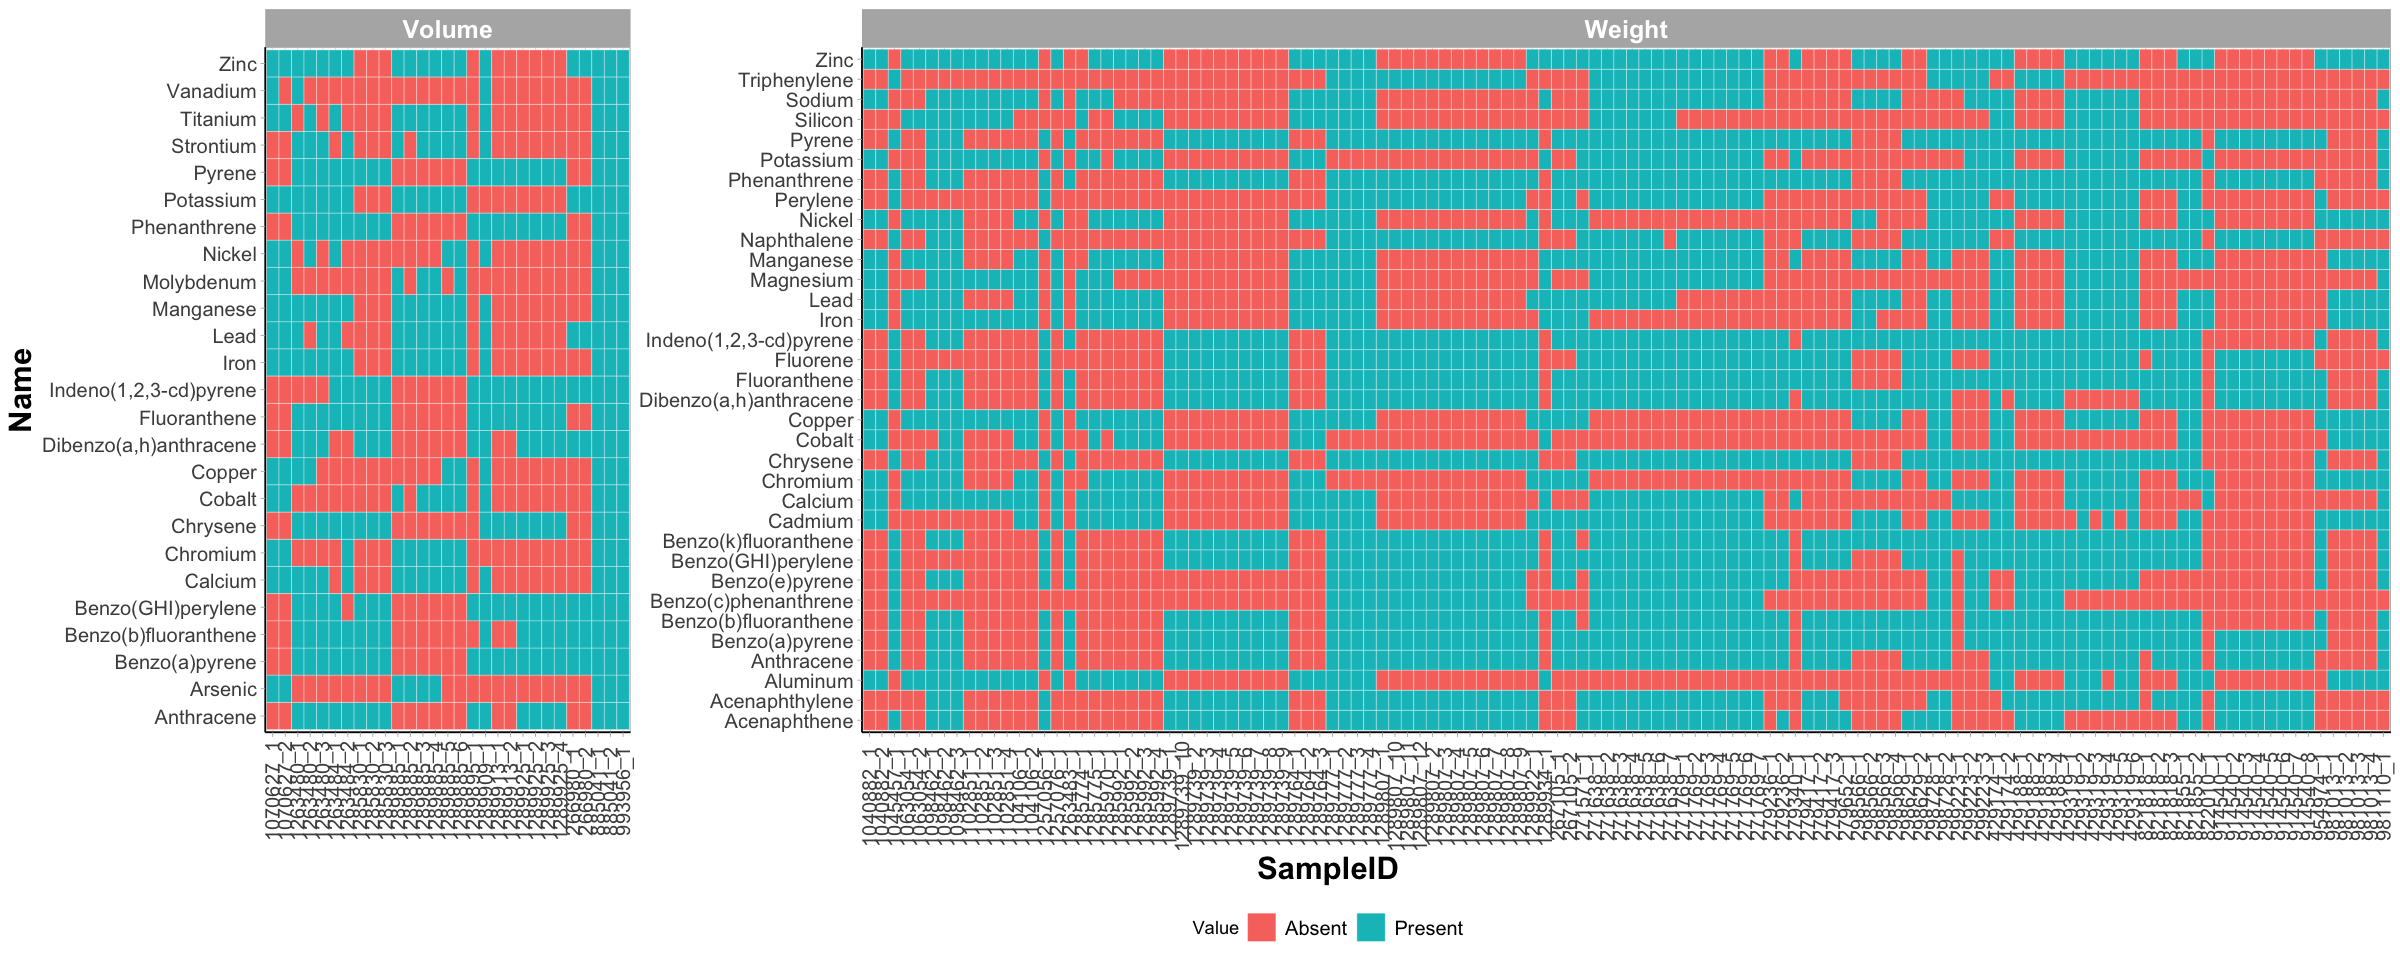

In [78]:
options(repr.plot.width=20, repr.plot.height=8) #changing size
ggplot(data = heat_map_df, aes(x = SampleID, y = Name, fill = Value)) + 
  geom_tile(color = "white") + 

  ggh4x::facet_grid2(.~ Metric, scales = 'free', independent = "y", space = "free") + 

  theme_light() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = "bottom", #removing legend
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold"))  #changes size of facet y axis 